In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob

In [2]:
# Define the path pattern for all tracking datasets
tracking_files_pattern = "data/tracking_week_*.csv"

# Columns needed from tracking data
tracking_columns = ['gameId', 'playId', 'frameType', 'event']

# Read and concatenate all tracking datasets with necessary columns only
tracking_files = glob.glob(tracking_files_pattern)
tracking_data_list = []
for file in tracking_files:
    df = pd.read_csv(file, usecols=tracking_columns)
    tracking_data_list.append(df)
tracking_data = pd.concat(tracking_data_list, ignore_index=True)

# Path for plays dataset
plays_path = 'data/plays.csv'

In [3]:
# Columns needed from plays data
plays_columns = [
    'gameId',
    'playId',
    'offenseFormation',
    'receiverAlignment',
    'playClockAtSnap',
    'absoluteYardlineNumber',
    'quarter',
    'down',
    'yardsToGo',
    'pff_passCoverage',
    'pff_manZone',
    'gameClock',
    'passResult',
    'playDescription'  # Include if needed for playType extraction
]

# Load plays dataset with necessary columns only
plays = pd.read_csv(plays_path, usecols=plays_columns)

# Add 'playType' column based on play description (assuming you have the extract_middle_part function)
def extract_middle_part(description):
    if not isinstance(description, str):
        return None
    words = description.split()
    for i, word in enumerate(words[:-1]):
        if word in {"pass", "scrambles", "right", "left", "sacked", "up"}:
            if word == "sacked":
                return word
            elif words[i:i+2] in [["right", "guard"], ["left", "guard"]]:
                return ' '.join(words[i:i+2])
            return ' '.join(words[i:i+3])

# Apply the function to create 'playType'
plays['playType'] = plays['playDescription'].apply(extract_middle_part)

In [4]:
# Define recode mapping
recode_mapping = {
    'pass short right': 'pass short',
    'scrambles right end': 'scramble',
    'right end to': 'rush',
    'pass short middle': 'pass short',
    'up the middle': 'rush',
    'pass deep right': 'pass deep',
    'right guard': 'rush',
    'pass short left': 'pass short',
    'sacked': None,
    'right tackle to': 'rush',
    'pass incomplete deep': 'pass deep',
    'pass incomplete short': 'pass short',
    'left tackle to': 'rush',
    'left end to': 'rush',
    'left guard': 'rush',
    'scrambles up the': 'scramble',
    'pass deep left': 'pass deep',
    'scrambles left end': 'scramble',
    'pass deep middle': 'pass deep',
    'right end ran': 'rush',
    'right end for': 'rush',
    'scrambles left tackle': 'scramble',
    'right end pushed': 'rush',
    None: None,
    'scrambles right guard': 'scramble',
    'left end pushed': 'rush',
    'left tackle pushed': 'rush',
    'scrambles left guard': 'scramble',
    'right tackle for': 'rush',
    'left end for': 'rush',
    'scrambles right tackle': 'scramble',
    'left tackle for': 'rush',
    'right tackle ran': 'rush',
    'left end ran': 'rush',
    'left tackle ran': 'rush',
    'right tackle pushed': 'rush',
    'pass intended for': None
}

# Apply recoding
plays['playType'] = plays['playType'].map(recode_mapping)
# plays = plays[plays['playType'] != 'scramble']

# Merge tracking data with plays data on 'gameId' and 'playId'
merged_data = pd.merge(tracking_data, plays, on=['gameId', 'playId'], how='inner')

print("Tracking and plays data merged successfully!")

Tracking and plays data merged successfully!


In [5]:
plays['playType'].unique()

array(['pass short', 'scramble', 'rush', 'pass deep', None], dtype=object)

In [6]:
# Filter the dataset for before-snap data
before_snap_data = merged_data[merged_data['frameType'] == 'BEFORE_SNAP']

# Select predictors (before-snap features) and target ('playType' column)
predictors = [
    'event',
    'offenseFormation',
    'receiverAlignment',
    'playClockAtSnap',
    'absoluteYardlineNumber',
    'quarter',
    'down',
    'yardsToGo',
    'pff_passCoverage',
    'pff_manZone',
    'gameClock'
]

target = 'playType'

# Include 'gameId' and 'playId' in the filtered data
ids = ['gameId', 'playId']

# Filter rows where predictors and target are not NaN
filtered_data = before_snap_data[ids + predictors + [target]]
filtered_data = filtered_data.dropna(subset=predictors + [target])

# Keep only one row for each play
filtered_data = filtered_data.groupby(['gameId', 'playId']).last().reset_index()

# Convert gameClock from 'MM:SS' format to total seconds
filtered_data['gameClock'] = filtered_data['gameClock'].apply(
    lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if pd.notnull(x) else None
)

# Ensure the column is numeric
filtered_data['gameClock'] = pd.to_numeric(filtered_data['gameClock'])

filtered_data.shape

(15237, 14)

In [7]:
filtered_data.tail(10)

,gameId,playId,event,offenseFormation,receiverAlignment,playClockAtSnap,absoluteYardlineNumber,quarter,down,yardsToGo,pff_passCoverage,pff_manZone,gameClock,playType
15227,2022110700,3480,line_set,SHOTGUN,2x2,7.0,69,4,2,10,Cover-3,Zone,262,pass short
15228,2022110700,3560,shift,SHOTGUN,3x1,13.0,88,4,1,10,Quarters,Zone,250,rush
15229,2022110700,3581,man_in_motion,SHOTGUN,2x2,5.0,82,4,2,4,Quarters,Zone,209,rush
15230,2022110700,3602,line_set,PISTOL,2x1,14.0,75,4,1,10,Cover-3,Zone,203,rush
15231,2022110700,3630,shift,PISTOL,2x2,7.0,75,4,2,10,Quarters,Zone,199,rush
15232,2022110700,3658,line_set,PISTOL,3x1,14.0,66,4,3,1,Cover-0,Man,194,rush
15233,2022110700,3686,line_set,I_FORM,2x1,4.0,64,4,1,10,Cover-0,Man,151,rush
15234,2022110700,3707,line_set,PISTOL,2x1,25.0,59,4,2,5,Cover-0,Man,120,rush
15235,2022110700,3740,man_in_motion,PISTOL,2x1,2.0,55,4,3,1,Cover-0,Man,75,rush
15236,2022110700,3787,line_set,SHOTGUN,2x2,18.0,21,4,1,10,Quarters,Zone,23,rush


In [8]:
# One-hot encode categorical columns using pd.get_dummies
encoded_categorical = pd.get_dummies(filtered_data[['event',
                       'offenseFormation',
                       'receiverAlignment',
                       'pff_manZone',
                       'pff_passCoverage']])

# Combine encoded categorical columns with numerical predictors
numerical_columns = ['playClockAtSnap',
                     'absoluteYardlineNumber',
                     'quarter',
                     'down',
                     'yardsToGo',
                     'gameClock']

X = pd.concat([encoded_categorical, filtered_data[numerical_columns]], axis=1)

# Ensure that the target variable matches the rows in the feature matrix
y = filtered_data['playType']

# Check consistency
assert X.shape[0] == y.shape[0], f"Mismatch in the number of rows: X has {X.shape[0]}, y has {y.shape[0]}."

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
# Fit a Random Forest model
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

   pass deep       0.13      0.01      0.03       355
  pass short       0.62      0.73      0.67      1811
        rush       0.65      0.68      0.66      1553
    scramble       0.00      0.00      0.00        91

    accuracy                           0.63      3810
   macro avg       0.35      0.36      0.34      3810
weighted avg       0.57      0.63      0.59      3810



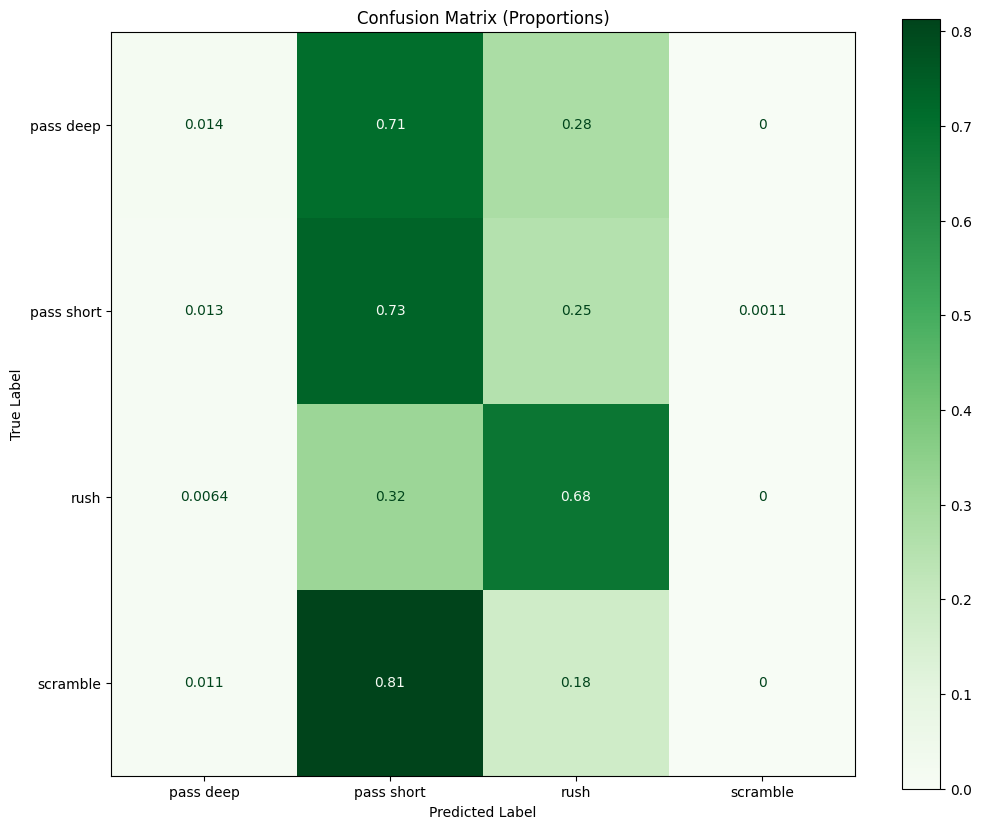

In [10]:
# Plot the confusion matrix as proportions
cm = confusion_matrix(y_test, y_pred, labels=model.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='Greens', ax=ax, colorbar=True)  # Change color scale to 'Greens'
plt.title("Confusion Matrix (Proportions)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

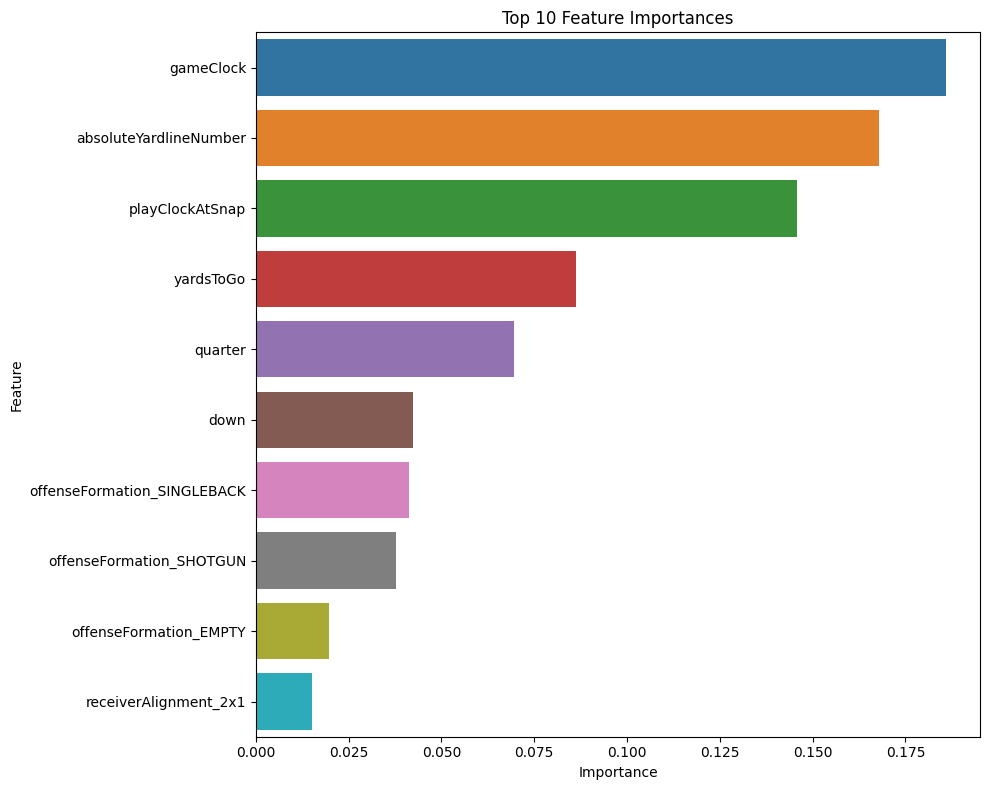

In [11]:
# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance['Importance'][:10], y=feature_importance['Feature'][:10])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()